In [25]:
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pyspark import SparkConf, SparkContext
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
conf = SparkConf().setAppName("LogisticRegression").setMaster("local[4]")
sc = SparkContext(conf=conf)

In [31]:
DATA_PATH = "data/cardio_train.csv"
NUMERIC_COLUMNS = [0, 2, 3, 4, 5]
EPOCHS = 50
ETA = 1e-4
NUM_WEIGHTS = 12

In [32]:
data = pd.read_csv(DATA_PATH, sep=";")
data.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [36]:
data.shape

(70000, 13)

In [38]:
def read_data():
    # read data
    data = pd.read_csv(DATA_PATH, sep=";")

    # gender preprocessing
    data["gender"] = data["gender"] - 1

    # extract x, y
    data = data.values[:, 1:]
    x, y = data[:, :-1], data[:, -1]

    # train test split
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=6/7)

    # standardize
    mean = x_train[:, NUMERIC_COLUMNS].mean(axis=0)
    std = x_train[:, NUMERIC_COLUMNS].std(axis=0)
    x_train[:, NUMERIC_COLUMNS] = (x_train[:, NUMERIC_COLUMNS] - mean) / (std + 1e-8)
    x_test[:, NUMERIC_COLUMNS] = (x_test[:, NUMERIC_COLUMNS] - mean) / (std + 1e-8)

    # append bias term
    N_train = x_train.shape[0]
    N_test = x_test.shape[0]
    x_train = np.concatenate([np.ones((N_train, 1)), x_train], axis=1)
    x_test = np.concatenate([np.ones((N_test, 1)), x_test], axis=1)

    return x_train, y_train, x_test, y_test

In [7]:
def parse_data(x, y):
    N = x.shape[0]
    return list(map(lambda i: (x[i], y[i]), range(N)))

In [28]:
def initialize_weights(num_weights):
    w = np.random.randn(num_weights)
    return w

In [22]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [37]:
def compute_accuracy(y_pred, y_true):
    y_pred[y_pred < 0.5] = 0
    y_pred[y_pred >= 0.5] = 1

    acc = (y_true == y_pred).astype(np.float32).mean()
    return acc

In [56]:
def train_logistic_regression():
    # read data
    x_train, y_train, x_test, y_test = read_data()

    # data visualize
    pca = PCA(n_components=2)
    x_train_pca = pca.fit_transform(x_train)

    plt.scatter(x_train_pca[y_train == 0, 0], x_train_pca[y_train == 0, 1], label="label 0", color="blue", alpha=0.3, s=2)
    plt.scatter(x_train_pca[y_train == 1, 0], x_train_pca[y_train == 1, 1], label="label 1", color="orange", alpha=0.3, s=2)
    plt.title("train data")
    plt.legend()
    plt.show()
    
    x_test_pca = pca.transform(x_test)

    plt.scatter(x_test_pca[y_test == 0, 0], x_test_pca[y_test == 0, 1], label="label 0", color="blue", alpha=0.3, s=2)
    plt.scatter(x_test_pca[y_test == 1, 0], x_test_pca[y_test == 1, 1], label="label 1", color="orange", alpha=0.3, s=2)
    plt.title("test data")
    plt.legend()
    plt.show()

    # prepare data
    train_data = sc.parallelize(parse_data(x_train, y_train))
    test_data = sc.parallelize(parse_data(x_test, y_test))

    # initialize weights
    w = initialize_weights(NUM_WEIGHTS)
    w_bc = sc.broadcast(w)

    # training
    for e in range(EPOCHS):
        # compute gradients
        grads = train_data.map(lambda kv: (kv[1] - sigmoid(np.dot(w_bc.value, kv[0])))*kv[0]) \
                          .reduce(lambda a, b: a + b)

        # weights update
        w = w + ETA*grads
        w_bc.unpersist()
        w_bc = sc.broadcast(w)

    # compute prediction
    y_train_pred = train_data.map(lambda kv: sigmoid(np.dot(w_bc.value, kv[0]))) \
                             .collect()
    y_test_pred = test_data.map(lambda kv: sigmoid(np.dot(w_bc.value, kv[0]))) \
                           .collect()

    y_train_pred = np.array(y_train_pred)
    y_test_pred = np.array(y_test_pred)

    print(f"Train accuracy: {compute_accuracy(y_train_pred, y_train)}")
    print(f"Test accuracy: {compute_accuracy(y_test_pred, y_test)}")

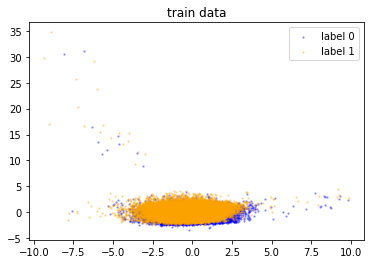

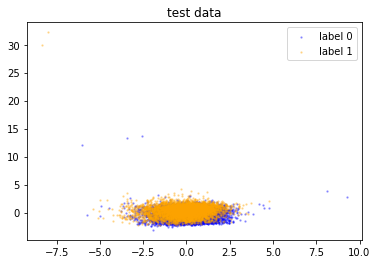

Train accuracy: 0.5615833401679993
Test accuracy: 0.5604000091552734


In [57]:
train_logistic_regression()